<a href="https://colab.research.google.com/github/wasineer-dev/braid/blob/develop/keras_tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf

from time import time as timer
from scipy.stats import chi2_contingency

MAX_ITERATION = 20

class CMeanFieldAnnealing:

    def __init__(self, Nproteins, Nk):
        self.lstExpectedLikelihood = []
        self.mIndicatorQ = np.zeros((Nproteins, Nk), dtype=float)

    def tf_annealing(self, mix_p, mObservationG, Nproteins, Nk, psi):

        matA = tf.convert_to_tensor(mObservationG.mTrials - mObservationG.mObserved, dtype=tf.float32)
        matB = tf.convert_to_tensor(psi*mObservationG.mObserved, dtype=tf.float32)
        tfArray = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
        for i in range(Nproteins):
            tfArray = tfArray.write(i, self.mIndicatorQ[i])
        
        gamma = 1000.0
        nIteration = 0
        while(nIteration < MAX_ITERATION and gamma > 1.0):
            for i in range(Nproteins):        
                tQ = tfArray.stack()
                fn_out = tf.tensordot(matA[i], tQ, axes=1) 
                fp_out = tf.tensordot(matB[i], 1.0 - tQ, axes=1)

                mLogLikelihood = fn_out + fp_out
                tfArray = tfArray.write(i, tf.nn.softmax(-gamma*mLogLikelihood))

            nIteration += 1
            gamma = gamma - 100.0
        print("Initialize with MFA: num. iterations = ", nIteration)
        self.mIndicatorQ = tfArray.stack().numpy()

    def estimate(self, mObservationG, Nproteins, Nk, psi):
        
        print('psi = ', psi)

        mix_p = (1.0/float(Nk))*np.ones(Nk, dtype=float)
        alpha1 = 1e-8
        for i in range(Nproteins):
            self.mIndicatorQ[i] = np.random.uniform(0.0, 1.0, size=Nk)
            self.mIndicatorQ[i] = (self.mIndicatorQ[i] + alpha1)/(np.sum(self.mIndicatorQ[i]) + alpha1*Nproteins)

        self.tf_annealing(mix_p, mObservationG, Nproteins, Nk, psi)
        
    def find_argmax(self):
        self.indicatorVec = np.argmax(self.mIndicatorQ, axis=1)

    def computeErrorRate(self, mObservationG, Nproteins):
        
        # self.find_lin_dependent()
        self.find_argmax()

        rnk = np.linalg.matrix_rank(self.mIndicatorQ)
        print("Indicator matrix had rank = " + str(rnk))
        nClusters = len(np.unique(self.indicatorVec))
        print("Number of clusters used: " + str(nClusters))

        countTp = 0
        countTn = 0
        countFn = 0
        countFp = 0
        sumSameCluster = 0
        sumDiffCluster = 0
        for i in range(Nproteins):
            for j in mObservationG.lstAdjacency[i]:
                t = mObservationG.mTrials[i][j]
                s = mObservationG.mObserved[i][j]
                assert(s <= t)
                if (self.indicatorVec[i] == self.indicatorVec[j]):
                    countTp += s
                    countFn += (t - s)
                    sumSameCluster += t
                else:
                    countTn += (t - s)
                    countFp += s
                    sumDiffCluster += t

        counts = countFn + countFp
        fn = 0.0
        fp = 0.0
        assert(sumSameCluster > 0)
        fn = float(countFn)/float(sumSameCluster)
        assert(sumDiffCluster > 0)
        fp = float(countFp)/float(sumDiffCluster)
        psi = (-np.log(fp) + np.log(1.0 - fn))/(-np.log(fn) + np.log(1.0 - fp))
        likelihood = 0.0 
        for i in np.arange(Nproteins):
            for j in np.arange(i+1, Nproteins):
                t = mObservationG.mTrials[i][j]
                s = mObservationG.mObserved[i][j]
                if (self.indicatorVec[i] == self.indicatorVec[j]):
                  likelihood += (t-s)
                else:    
                  likelihood += s*psi

        fdr = float(countFp)/float(countTp + countFp)
        fdr2 = float(countFn)/float(countTn + countFn)
        precision = float(countTp)/float(countTp + countFp)
        recall = float(countTp)/float(countTp + countFn)
        f1 = 2*(precision * recall)/(precision + recall)
        return (precision, recall, f1, likelihood)
        
class CountMatrixModel:
    
    def __init__(self, nProteins, bait_inds, incidence):

        self.nProteins = nProteins
        self.mObserved = np.zeros(shape=(nProteins, nProteins), dtype=int)
        for i, bait in zip(range(len(bait_inds)), bait_inds):
            for j in range(nProteins):
                if incidence[i,j]:
                    self.mObserved[j,:] += incidence[i,:] 
                    self.mObserved[:,j] += incidence[i,:]
    
        self.mTrials = np.zeros(shape=(nProteins, nProteins), dtype=int)
        for i, bait in zip(range(len(bait_inds)), bait_inds):
            for j in range(nProteins):
                if incidence[i,j]:
                    self.mTrials[j,:] += np.ones(nProteins, dtype=int) 
                    self.mTrials[:,j] += np.ones(nProteins, dtype=int)

        for i in range(nProteins):
            assert(np.sum(self.mTrials[i,:]) == np.sum(self.mTrials[:,i]))

        #
        # Create the adjacency list
        #
        self.lstAdjacency = {}
        for i in np.arange(nProteins):
            self.lstAdjacency[i] = set()
            for j in np.arange(nProteins):
                t = self.mTrials[i][j]
                if (i < j):
                    s = self.mObserved[i][j] 
                else:
                    s = self.mObserved[j][i] 
                assert(s <= t)
                if (i != j and t > 0):
                    self.lstAdjacency[i].add(j)
#
# TODO: cpmFunc can be countSpokeModel or countMatrixModel
#
class CInputSet:

    def __init__(self, filename, cpmFunc=None):
        super().__init__()

        listBaits = list()
        with open(filename) as fh:
            setProteins = set()
            for line in fh:
                lst = line.rstrip().split(',')
                bait = lst[0]
                listBaits.append(bait)
                setProteins = setProteins.union(set(lst))
            print('Number of proteins ' + str(len(setProteins)))
            fh.close()

        self.aSortedProteins = np.sort(np.array(list(setProteins), dtype='U21'))
        bait_inds = np.searchsorted(self.aSortedProteins, np.array(listBaits, dtype='U21'))
        
        print('Number of purifications ' + str(len(bait_inds)))

        nProteins = len(self.aSortedProteins)
        self.incidence = np.zeros(shape=(len(bait_inds), nProteins), dtype=int)
        with open(filename) as fh:
            lineCount = 0
            for line in fh:
                lst = line.rstrip().split(',')
                prey_inds = np.searchsorted(self.aSortedProteins, np.array(lst, dtype='U21'))           
                for id in prey_inds:
                    self.incidence[lineCount][id] = 1
                lineCount += 1
            fh.close()
            
        self.observationG = CountMatrixModel(nProteins, bait_inds, self.incidence)

    def writeCluster2File(self, baseName, matQ, indVec):
        nRows, nCols = matQ.shape
        filePath = baseName + ".tab"
        with open(filePath, "w") as fh:
            for i in range(nRows):
                ind = indVec[i]
                fh.write(self.aSortedProteins[i] + '\t' + str(indVec[i]) + '\t' + str(max(matQ[ind])) + '\n')
            fh.close()
        filePath = baseName + ".csv"
        with open(filePath, "w") as fh:
            for k in range(nCols):
                inds = list(i for i in range(nRows) if indVec[i] == k)
                for j in inds:
                    protein = self.aSortedProteins[j].split('__')[0] 
                    fh.write(protein + '\t')
                fh.write('\n')
            fh.close()
    
    def writeLabel2File(self, indVec):
        clusters = {}
        for i,k in enumerate(indVec):
            if k not in clusters.keys():
                clusters[k] = set()
            clusters[k].add(i)

        with open("out.csv", "w") as fh:
            for i, k in enumerate(clusters):
                for v in clusters[k]:
                    protein = self.aSortedProteins[v].split('__')[0] 
                    fh.write(protein + '\t')
                fh.write('\n')
            fh.close()

def clustering(inputSet, Nk, psi, baseName):
    fn = 0.8
    fp = 0.04
    nProteins = inputSet.observationG.nProteins
    cmfa = CMeanFieldAnnealing(nProteins, Nk) # default

    funcInfer = cmfa

    ts = timer()
    # alpha = 1e-2
    funcInfer.estimate(inputSet.observationG, nProteins, Nk, psi) 
    te = timer()
    print("Time running MFA: ", te-ts)
    
    funcInfer.find_argmax()
    
    inputSet.writeCluster2File(baseName, funcInfer.mIndicatorQ, funcInfer.indicatorVec)
    

    

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install keras-tuner -q

     |████████████████████████████████| 135 kB 5.3 MB/s 
     |████████████████████████████████| 1.6 MB 49.1 MB/s 


In [ ]:
inputSet = CInputSet("/content/drive/MyDrive/gavin2006.csv")

Number of proteins 2760
Number of purifications 2166


In [ ]:
import tensorflow_probability as tfp
from time import time as timer
import keras_tuner

Nk = 300
nProteins = inputSet.observationG.nProteins
cmfa = CMeanFieldAnnealing(nProteins, Nk) # default

@tf.custom_gradient
def loss(psi):
    cmfa.estimate(inputSet.observationG, nProteins, Nk, psi.numpy())  
    (fn, fp, p, total_loss) = cmfa.computeErrorRate(inputSet.observationG, nProteins)
    regularization_penalty = l1_regularizer(psi)      
    regularized_loss = total_loss + regularization_penalty # this loss needs to be minimized
    def grad(upstream):
      return upstream * (regularized_loss/3e6) 
    return regularized_loss, grad

def likelihood_loss(x):
    cmfa.estimate(inputSet.observationG, nProteins, Nk, x)  
    (fn, fp, p, total_loss) = cmfa.computeErrorRate(inputSet.observationG, nProteins)
    regularization_penalty = 0.01*x      
    regularized_loss = total_loss + regularization_penalty # this loss needs to be minimized
    print(regularized_loss)
    return regularized_loss

minimum = np.array([1.0, 1.0])  # The center of the quadratic bowl.
scales = np.array([2.0, 3.0])  # The scales along the two axes.

# The objective function and the gradient.
def quadratic_loss_and_gradient(x):
  print(tf.reduce_sum(
          scales * tf.math.squared_difference(x, minimum), axis=-1))
  return tfp.math.value_and_gradient(
      lambda x: tf.reduce_sum(
          scales * tf.math.squared_difference(x, minimum), axis=-1),
      x)

start = tf.constant([0.6, 0.8])  # Starting point for the search.
optim_results = tfp.optimizer.bfgs_minimize(
    quadratic_loss_and_gradient, initial_position=start, tolerance=1e-8)

# Check that the search converged
assert(optim_results.converged)
# Check that the argmin is close to the actual value.
np.testing.assert_allclose(optim_results.position, minimum)
# Print out the total number of function evaluations it took. Should be 5.
print ("Function evaluations: %d" % optim_results.num_objective_evaluations)

def likelihood_loss_and_gradient(xs):
  return tfp.math.value_and_gradient(lambda x: likelihood_loss(x), xs)

#psi = tf.constant([10.0])
#optim_results = tfp.math.minimize(
#      lambda: likelihood_loss(x),
#      optimizer=tf.optimizers.Adam(learning_rate=0.1),
#      num_steps=20)

class RandomSearchTuner(keras_tuner.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        # Get the hp from trial.
        hp = trial.hyperparameters
        # Define "x" as a hyperparameter.
        x = hp.Float("x", min_value=1.0, max_value=10.0)
        # Return the objective value to minimize.
        return likelihood_loss(x)

tuner = RandomSearchTuner(
    # No hypermodel or objective specified.
    max_trials=30,
    overwrite=True,
    directory="my_dir",
    project_name="random_search_tune",
)

# No need to pass anything to search()
# unless you use them in run_trial().
tuner.search(epochs=10)
print(tuner.get_best_hyperparameters()[0].get("x"))


Trial 36 Complete [00h 04m 08s]
default_objective: 3140255.545265245

Best default_objective So Far: 3140255.545265245
Total elapsed time: 02h 28m 12s

Search: Running Trial #37

Value             |Best Value So Far |Hyperparameter
7.4038            |1.3792            |x

psi =  7.403811366385403


KeyboardInterrupt: ignored

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

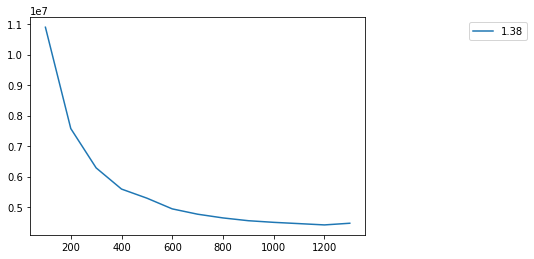

In [ ]:
def clustering(inputSet, k, psi):
    nProteins = inputSet.observationG.nProteins
    cmfa = CMeanFieldAnnealing(nProteins, k) # default

    funcInfer = cmfa        

    funcInfer.estimate(inputSet.observationG, nProteins, k, psi)
    (fn, fp, errs, f_last) = funcInfer.computeErrorRate(inputSet.observationG, nProteins)
    return f_last

psi = tuner.get_best_hyperparameters()[0].get("x")
max_k = int(inputSet.observationG.nProteins/2)
ks = np.arange(100, max_k, 100)
ls = []
for i, k in enumerate(ks):
    ls.append(clustering(inputSet, k, psi))
bics = []
for i, f in enumerate(ls):
    bics.append(np.log(nProteins)*float(ks[i]) + 2.0*ls[i])
plt.plot(ks, bics, label="{:.2f}".format(psi))
plt.legend(bbox_to_anchor=(1.5, 1.0))
plt.show()

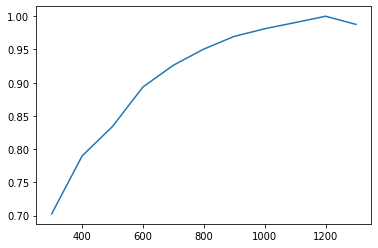

In [ ]:
xs = ks[2:]
ys = bics[2:]
plt.plot(xs, np.min(ys)/ys)
plt.show()

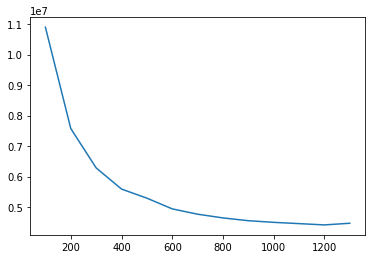

In [ ]:
fig = plt.figure()
plt.plot(ks, bics)
plt.show()

In [ ]:
fig.savefig("gavin2006_bic.png")